<a href="https://colab.research.google.com/github/yash-clear/neural-machine-translation-with-attention/blob/main/Attention_is_all_you_need_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RESEARCH PAPER CHOSEN: ATTENTION IS ALL YOU NEED


In [ ]:
import math
import os
import gc
import time
import re

import tensorflow as tf
import pandas as pd
import numpy as np

from google.colab import drive
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow_datasets as tfds

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
%matplotlib inline 

Mounting the drive

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Global Path Variables 
root_folder='/content/drive'
data_folder_name='MyDrive/dataset/'
checkpoint_folder = "MyDrive/projects/checkpoints/" # To create checkpoints for the model
train_filename='deu.txt'

#Directories
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
train_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))
checkpoint_path = os.path.abspath(os.path.join(root_folder, checkpoint_folder))
NB_Path_lang1=DATA_PATH+"/nonbreaking_prefix.en"
NB_Path_lang2=DATA_PATH+"/nonbreaking_prefix.de"

In [ ]:
# Parameters for our model
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'
NUM_SAMPLES = 80000 
MAX_VOCAB_SIZE = 2**14

BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 10  # Number of epochs to train for.
MAX_LENGTH = 15

# Both train and test set are in the root data directory
train_path = DATA_PATH


In [ ]:
print(DATA_PATH)

/content/drive/MyDrive/dataset


### preprocessing non-breaking texts

In [ ]:

def preprocess_text_nonbreaking(corpus, non_breaking_prefixes):
  corpus_cleaned = corpus
  
  for prefix in non_breaking_prefixes:
    corpus_cleaned = corpus_cleaned.replace(prefix, prefix + '$$$')
  
  corpus_cleaned = re.sub(r"\.(?=[0-9]|[a-z]|[A-Z])", ".$$$", corpus_cleaned)
  # Remove the $$$ mark
  corpus_cleaned = re.sub(r"\.\$\$\$", '', corpus_cleaned)
  # Remove multiple white spaces
  corpus_cleaned = re.sub(r"  +", " ", corpus_cleaned)

  return corpus_cleaned

### Load the dataset 

In [ ]:

def load_data( NB_Path_lang1, NB_path_lang2,train_filenamepath):

  with open(NB_Path_lang1, mode = "r", encoding = "utf-8") as f:
      non_breaking_prefix_en = f.read()

  with open(NB_path_lang2,mode = "r", encoding = "utf-8") as f:
      non_breaking_prefix_de = f.read()

  non_breaking_prefix_en = non_breaking_prefix_en.split("\n")
  non_breaking_prefix_en = [' ' + pref + '.' for pref in non_breaking_prefix_en]
  non_breaking_prefix_de = non_breaking_prefix_de.split("\n")
  non_breaking_prefix_de = [' ' + pref + '.' for pref in non_breaking_prefix_de]    

  df=pd.read_csv(train_filenamepath, sep="\t", header=None, names=[INPUT_COLUMN,TARGET_COLUMN], usecols=[0,1], 
                nrows=NUM_SAMPLES)

  # Preprocess the input data (English)
  input_data=df[INPUT_COLUMN].apply(lambda x : preprocess_text_nonbreaking(x, non_breaking_prefix_en)).tolist()

  # Preprocess and include the end of sentence token to the target text (German)
  target_data=df[TARGET_COLUMN].apply(lambda x : preprocess_text_nonbreaking(x, non_breaking_prefix_de)).tolist()

  return input_data,target_data


In [ ]:
def subword_tokenize(corpus, vocab_size, max_length):
  # Create the vocabulary using Subword tokenization
  tokenizer_corpus = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    corpus, target_vocab_size=vocab_size)
  # Get the final vocab size, adding the eos and sos tokens
  num_words = tokenizer_corpus.vocab_size + 2
  # Set eos and sos token
  sos_token = [num_words-2]
  eos_token = [num_words-1]
  # Tokenize the corpus
  sentences = [sos_token + tokenizer_corpus.encode(sentence) + eos_token
          for sentence in corpus]
  # Identify the index of the sentences longer than max length
  idx_to_remove = [count for count, sent in enumerate(sentences)
                 if len(sent) > max_length]
  #Pad the sentences
  sentences = tf.keras.preprocessing.sequence.pad_sequences(sentences,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=max_length)
  
  return sentences, tokenizer_corpus, num_words, sos_token, eos_token, idx_to_remove


In [ ]:
input_data,target_data=load_data(NB_Path_lang1,NB_Path_lang2,train_filenamepath)


In [ ]:
print('Number of sentences: ',len(input_data))
print(input_data[:5])
print(target_data[:5])

Number of sentences:  80000
['Go.', 'Hi.', 'Hi.', 'Run!', 'Run.']
['Geh.', 'Hallo!', 'Grüß Gott!', 'Lauf!', 'Lauf!']


### Tokenize and pad

In [ ]:

encoder_inputs, tokenizer_inputs, num_words_inputs, sos_token_input, eos_token_input, del_idx_inputs= subword_tokenize(input_data,MAX_VOCAB_SIZE, MAX_LENGTH)
decoder_outputs, tokenizer_outputs, num_words_output, sos_token_output, eos_token_output, del_idx_outputs = subword_tokenize(target_data, MAX_VOCAB_SIZE, MAX_LENGTH)



In [ ]:
print(encoder_inputs[:5], sos_token_input, eos_token_input)
print(decoder_outputs[:5], sos_token_output, eos_token_output)

[[11286  7301 11076 11287     0     0     0     0     0     0     0     0
      0     0     0]
 [11286  1727 11076 11287     0     0     0     0     0     0     0     0
      0     0     0]
 [11286  1727 11076 11287     0     0     0     0     0     0     0     0
      0     0     0]
 [11286  7238 11063 11287     0     0     0     0     0     0     0     0
      0     0     0]
 [11286  7238 11076 11287     0     0     0     0     0     0     0     0
      0     0     0]] [11286] [11287]
[[18946  5049 18736 18947     0     0     0     0     0     0     0     0
      0     0     0]
 [18946  1249 18723 18947     0     0     0     0     0     0     0     0
      0     0     0]
 [18946  5032  2130 18723 18947     0     0     0     0     0     0     0
      0     0     0]
 [18946  9941 18723 18947     0     0     0     0     0     0     0     0
      0     0     0]
 [18946  9941 18723 18947     0     0     0     0     0     0     0     0
      0     0     0]] [18946] [18947]


In [ ]:
print('Size of Input Vocabulary: ', num_words_inputs)
print('Size of Output Vocabulary: ', num_words_output)

Size of Input Vocabulary:  11288
Size of Output Vocabulary:  18948


## Define a dataset

In [ ]:
 
dataset = tf.data.Dataset.from_tensor_slices(
    (encoder_inputs, decoder_outputs))
dataset = dataset.shuffle(len(input_data), reshuffle_each_iteration=True).batch(
    BATCH_SIZE, drop_remainder=True)

dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

Positional encoding: in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the  where pos is the position and i is the dimension, we use sine and cosine functions of different frequencies:

PE(pos;2i) = sin(pos=10000^(2i/dmodel)

PE(pos;2i+1) = cos(pos=10000^(2i/dmodel)


In [ ]:
class PositionalEncoding(layers.Layer):

    def __init__(self):
        super(PositionalEncoding, self).__init__()
    
    def get_angles(self, pos, i, d_model):
        angles = 1 / np.power(10000., (2*(i//2)) / np.float32(d_model))
        return pos * angles 

    def call(self, inputs):
        
        seq_length = inputs.shape.as_list()[-2]
        d_model = inputs.shape.as_list()[-1]
        
        angles = self.get_angles(np.arange(seq_length)[:, np.newaxis],
                                 np.arange(d_model)[np.newaxis, :],
                                 d_model)
       
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        
        pos_encoding = angles[np.newaxis, ...]
        
        return inputs + tf.cast(pos_encoding, tf.float32)

In [ ]:
class EncoderLayer(layers.Layer):
    
    def __init__(self, FFN_units, n_heads, dropout_rate):
        super(EncoderLayer, self).__init__()
        # Hidden units of the feed forward component
        self.FFN_units = FFN_units
        # Set the number of projectios or heads
        self.n_heads = n_heads
        # Dropout rate
        self.dropout_rate = dropout_rate
    
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        # Build the multihead layer
        self.multi_head_attention = MultiHeadAttention(self.n_heads)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        # Layer Normalization
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        # Fully connected feed forward layer
        self.ffn1_relu = layers.Dense(units=self.FFN_units, activation="relu")
        self.ffn2 = layers.Dense(units=self.d_model)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        # Layer normalization
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, mask, training):
        attention = self.multi_head_attention(inputs,
                                              inputs,
                                              inputs,
                                              mask)
        attention = self.dropout_1(attention, training=training)
        
        attention = self.norm_1(attention + inputs)
        # Call to the FC layer
        outputs = self.ffn1_relu(attention)
        outputs = self.ffn2(outputs)
        outputs = self.dropout_2(outputs, training=training)
        # Call to residual connection and the layer normalization
        outputs = self.norm_2(outputs + attention)
        
        return outputs

In [ ]:
class Encoder(layers.Layer):
    
    def __init__(self,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="encoder"):
        super(Encoder, self).__init__(name=name)
        self.n_layers = n_layers
        self.d_model = d_model
        # The embedding layer
        self.embedding = layers.Embedding(vocab_size, d_model)
        # Positional encoding layer
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        # Stack of n layers of multi-head attention and FC
        self.enc_layers = [EncoderLayer(FFN_units,
                                        n_heads,
                                        dropout_rate) 
                           for _ in range(n_layers)]
    
    def call(self, inputs, mask, training):
        # Get the embedding vectors
        outputs = self.embedding(inputs)
        # Scale the embeddings by sqrt of d_model
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Positional encodding
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        # Call the stacked layers
        for i in range(self.n_layers):
            outputs = self.enc_layers[i](outputs, mask, training)

        return outputs

In [ ]:
class DecoderLayer(layers.Layer):
    
    def __init__(self, FFN_units, n_heads, dropout_rate):
        super(DecoderLayer, self).__init__()
        self.FFN_units = FFN_units
        self.n_heads = n_heads
        self.dropout_rate = dropout_rate
    
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        self.multi_head_causal_attention = MultiHeadAttention(self.n_heads)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
         
        self.multi_head_enc_dec_attention = MultiHeadAttention(self.n_heads)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
        # Feed foward
        self.ffn1_relu = layers.Dense(units=self.FFN_units,
                                    activation="relu")
        self.ffn2 = layers.Dense(units=self.d_model)
        self.dropout_3 = layers.Dropout(rate=self.dropout_rate)
        self.norm_3 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        # Call the masked causal attention
        attention = self.multi_head_causal_attention(inputs,
                                                inputs,
                                                inputs,
                                                mask_1)
        attention = self.dropout_1(attention, training)
        # Residual connection and layer normalization
        attention = self.norm_1(attention + inputs)
        # Call the encoder-decoder attention
        attention_2 = self.multi_head_enc_dec_attention(attention,
                                                  enc_outputs,
                                                  enc_outputs,
                                                  mask_2)
        attention_2 = self.dropout_2(attention_2, training)
        # Residual connection and layer normalization
        attention_2 = self.norm_2(attention_2 + attention)
        # Call the Feed forward
        outputs = self.ffn1_relu(attention_2)
        outputs = self.ffn2(outputs)
        outputs = self.dropout_3(outputs, training)
        # Residual connection and layer normalization
        outputs = self.norm_3(outputs + attention_2)
        
        return outputs

In [ ]:
class Decoder(layers.Layer):
    
    def __init__(self,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="decoder"):
        super(Decoder, self).__init__(name=name)
        self.d_model = d_model
        self.n_layers = n_layers
        # Embedding layer
        self.embedding = layers.Embedding(vocab_size, d_model)
        # Positional encoding layer
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        # Stacked layers of multi-head attention and feed forward
        self.dec_layers = [DecoderLayer(FFN_units,
                                        n_heads,
                                        dropout_rate) 
                           for _ in range(n_layers)]
    
    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        # Get the embedding vectors
        outputs = self.embedding(inputs)
        # Scale by sqrt of d_model
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Positional encodding
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        # Call the stacked layers
        for i in range(self.n_layers):
            outputs = self.dec_layers[i](outputs,
                                         enc_outputs,
                                         mask_1,
                                         mask_2,
                                         training)

        return outputs

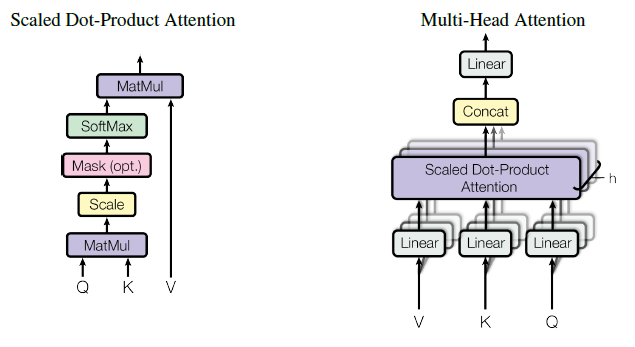

An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.


In [ ]:

def scaled_dot_product_attention(queries, keys, values, mask):
    product = tf.matmul(queries, keys, transpose_b=True)
    keys_dim = tf.cast(tf.shape(keys)[-1], tf.float32)
    scaled_product = product / tf.math.sqrt(keys_dim)
    if mask is not None:
        scaled_product += (mask * -1e9)
    attention = tf.matmul(tf.nn.softmax(scaled_product, axis=-1), values)
    
    return attention

In [ ]:
class MultiHeadAttention(layers.Layer):
    
    def __init__(self, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        assert self.d_model % self.n_heads == 0
        self.d_head = self.d_model // self.n_heads
        # Set the weight matrices for Q, K and V
        self.query_lin = layers.Dense(units=self.d_model)
        self.key_lin = layers.Dense(units=self.d_model)
        self.value_lin = layers.Dense(units=self.d_model)

        self.final_lin = layers.Dense(units=self.d_model)
        
    def split_proj(self, inputs, batch_size): 
        shape = (batch_size,
                 -1,
                 self.n_heads,
                 self.d_head)
        splited_inputs = tf.reshape(inputs, shape=shape) 
        return tf.transpose(splited_inputs, perm=[0, 2, 1, 3]) 
    
    def call(self, queries, keys, values, mask):

        batch_size = tf.shape(queries)[0]
   
        queries = self.query_lin(queries)
        keys = self.key_lin(keys)
        values = self.value_lin(values)
      
        queries = self.split_proj(queries, batch_size)
        keys = self.split_proj(keys, batch_size)
        values = self.split_proj(values, batch_size)
       
        attention = scaled_dot_product_attention(queries, keys, values, mask)
       
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(attention,
                                      shape=(batch_size, -1, self.d_model))
        
        outputs = self.final_lin(concat_attention)
        
        return outputs

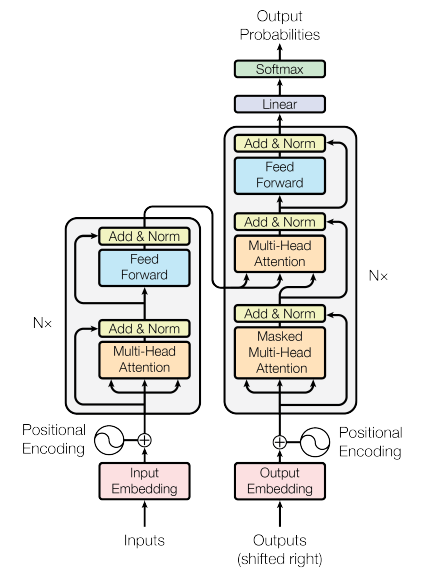

In [ ]:
class Transformer(tf.keras.Model):
    
    def __init__(self,
                 vocab_size_enc,
                 vocab_size_dec,
                 d_model,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 name="transformer"):
        super(Transformer, self).__init__(name=name)
        self.encoder = Encoder(n_layers,FFN_units, n_heads,dropout_rate,vocab_size_enc,d_model)
        self.decoder = Decoder(n_layers,FFN_units,n_heads, dropout_rate,vocab_size_dec,d_model)
        self.last_linear = layers.Dense(units=vocab_size_dec, name="lin_ouput")
    
    def create_padding_mask(self, seq):
        mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return mask[:, tf.newaxis, tf.newaxis, :]

    def create_look_ahead_mask(self, seq):
        seq_len = tf.shape(seq)[1]
        look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        return look_ahead_mask
    
    def call(self, enc_inputs, dec_inputs, training):
        enc_mask = self.create_padding_mask(enc_inputs)
        # Create the mask for the causal attention
        dec_mask_1 = tf.maximum(
            self.create_padding_mask(dec_inputs),
            self.create_look_ahead_mask(dec_inputs)
        )
        # Create the mask for the encoder-decoder attention
        dec_mask_2 = self.create_padding_mask(enc_inputs)
        # Call the encoder
        enc_outputs = self.encoder(enc_inputs, enc_mask, training)
        # Call the decoder
        dec_outputs = self.decoder(dec_inputs,enc_outputs,dec_mask_1,dec_mask_2, training)
        # Call the Linear and Softmax functions
        outputs = self.last_linear(dec_outputs)
        
        return outputs

In [ ]:

def loss_function(target, pred):
    mask = tf.math.logical_not(tf.math.equal(target, 0))
    loss_ = loss_object(target, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
def main_train(dataset, transformer, n_epochs, print_every=50):
  ''' Train the transformer model for n_epochs using the data generator dataset'''
  losses = []
  accuracies = []
  # In every epoch
  for epoch in range(n_epochs):
    print("Starting epoch {}".format(epoch+1))
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    for (batch, (enc_inputs, targets)) in enumerate(dataset):
        dec_inputs = targets[:, :-1]
        dec_outputs_real = targets[:, 1:]
        with tf.GradientTape() as tape:
            predictions = transformer(enc_inputs, dec_inputs, True)
            loss = loss_function(dec_outputs_real, predictions)
        gradients = tape.gradient(loss, transformer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
        # Save and store the metrics
        train_loss(loss)
        train_accuracy(dec_outputs_real, predictions)
        
        if batch % print_every == 0:
            losses.append(train_loss.result())
            accuracies.append(train_accuracy.result())
            print("Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}".format(
                epoch+1, batch, train_loss.result(), train_accuracy.result()))
            
    # Checkpoint the model on every epoch        
    ckpt_save_path = ckpt_manager.save()
    print("Saving checkpoint for epoch {} in {}".format(epoch+1,
                                                        ckpt_save_path))
    print("Time for 1 epoch: {} secs\n".format(time.time() - start))

  return losses, accuracies

### Set hyperparamters 




In [ ]:

D_MODEL = 512 
N_LAYERS = 4
FFN_UNITS = 512
N_HEADS = 8
DROPOUT_RATE = 0.1

## Training the model

In [ ]:

tf.keras.backend.clear_session()
# Create the Transformer model
transformer = Transformer(vocab_size_enc=num_words_inputs,
                          vocab_size_dec=num_words_output,
                          d_model=D_MODEL,
                          n_layers=N_LAYERS,
                          FFN_units=FFN_UNITS,
                          n_heads=N_HEADS,
                          dropout_rate=DROPOUT_RATE)

# Define a categorical cross entropy loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction="none")
# Define a metric to store the mean loss of every epoch
train_loss = tf.keras.metrics.Mean(name="train_loss")
# Define a matric to save the accuracy in every epoch
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")
# Create the scheduler for learning rate decay
leaning_rate = CustomSchedule(D_MODEL)
# Create the Adam optimizer
optimizer = tf.keras.optimizers.Adam(leaning_rate,beta_1=0.9,beta_2=0.98,epsilon=1e-9)
        

## Checkpoint 

In [ ]:
ckpt = tf.train.Checkpoint(transformer=transformer,
                        optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print("Last checkpoint restored.")

### Train

In [ ]:
# Train the model
losses, accuracies = main_train(dataset, transformer, EPOCHS, 100)

Starting epoch 1
Epoch 1 Batch 0 Loss 0.5337 Accuracy 0.3661
Epoch 1 Batch 100 Loss 0.5781 Accuracy 0.3513
Epoch 1 Batch 200 Loss 0.5793 Accuracy 0.3511
Epoch 1 Batch 300 Loss 0.5886 Accuracy 0.3495
Epoch 1 Batch 400 Loss 0.5953 Accuracy 0.3493
Epoch 1 Batch 500 Loss 0.5989 Accuracy 0.3489
Epoch 1 Batch 600 Loss 0.6024 Accuracy 0.3484
Epoch 1 Batch 700 Loss 0.6060 Accuracy 0.3481
Epoch 1 Batch 800 Loss 0.6075 Accuracy 0.3476
Epoch 1 Batch 900 Loss 0.6089 Accuracy 0.3474
Epoch 1 Batch 1000 Loss 0.6120 Accuracy 0.3472
Epoch 1 Batch 1100 Loss 0.6129 Accuracy 0.3472
Epoch 1 Batch 1200 Loss 0.6139 Accuracy 0.3471
Saving checkpoint for epoch 1 in /content/drive/MyDrive/projects/checkpoints/ckpt-7
Time for 1 epoch: 408.5590395927429 secs



### PLots

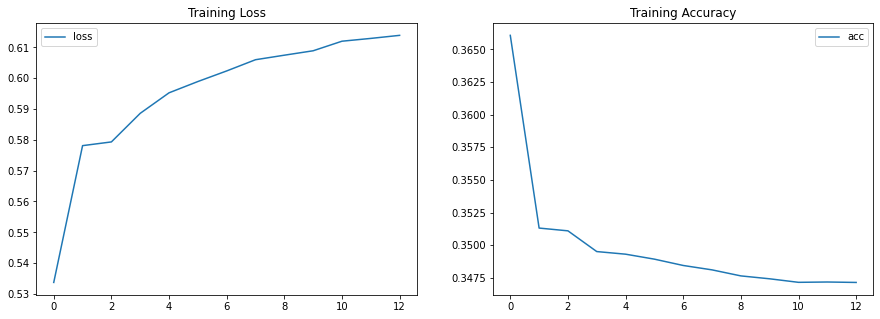

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# plot some data
ax1.plot(losses, label='loss')
#plt.plot(results.history['val_loss'], label='val_loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='acc')
#plt.plot(results.history['val_accuracy_fn'], label='val_acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()

### Let's predict

In [ ]:
def predict(inp_sentence, tokenizer_in, tokenizer_out, target_max_len):
    # Tokenize the input sequence using the tokenizer_in
    inp_sentence = sos_token_input + tokenizer_in.encode(inp_sentence) + eos_token_input
    enc_input = tf.expand_dims(inp_sentence, axis=0)

    # Set the initial output sentence to sos
    out_sentence = sos_token_output
    # Reshape the output
    output = tf.expand_dims(out_sentence, axis=0)

    # For max target len tokens
    for _ in range(target_max_len):
        # Call the transformer and get the logits 
        predictions = transformer(enc_input, output, False)
        # Extract the logists of the next word
        prediction = predictions[:, -1:, :]
        # The highest probability is taken
        predicted_id = tf.cast(tf.argmax(prediction, axis=-1), tf.int32)
        # Check if it is the eos token
        if predicted_id == eos_token_output:
            return tf.squeeze(output, axis=0)
        # Concat the predicted word to the output sequence
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)

## Get the predicted sequence for the input sentence

In [ ]:
def translate(sentence):
    
    output = predict(sentence, tokenizer_inputs, tokenizer_outputs, MAX_LENGTH).numpy()
    predicted_sentence = tokenizer_outputs.decode(
        [i for i in output if i < sos_token_output]
    )

    return predicted_sentence

## Show the translations

In [ ]:

sentence = "I am running"
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: I am running
Output sentence: Ich laufe gern.


In [ ]:
sentence = "Who are you ?"
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: Who are you ?
Output sentence: Wer ist Sie?
